In [1]:
import numpy as np
from scipy.stats import describe, norm
import matplotlib.pyplot as plt
import sobol
import optunity.optunity as opt
import GPy

import time
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial

In [2]:
def f(x, y):
    return x**2 - x + y**2 + y - np.cos(2*np.pi*x - np.pi) - np.cos(2*np.pi*y + np.pi) + 2.5

(1200, 1200)


<a list of 14 text.Text objects>

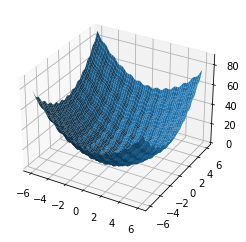

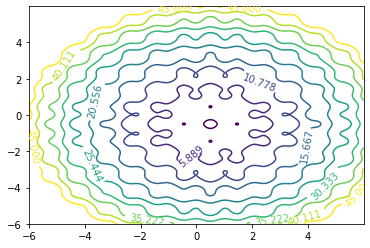

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-6.0, 6.0, 0.01)
X, Y = np.meshgrid(x, y)
zs = np.array(f(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)
print(Z.shape)
ax.plot_surface(X, Y, Z)

plt.figure()
levels = np.linspace(1, 45, 10)
CS = plt.contour(X, Y, Z, levels=levels)
plt.clabel(CS, inline=1, fontsize=10)

In [4]:
n = 60
xy_min = [-6, -6]
xy_max = [6, 6]
data = np.random.uniform(low=xy_min, high=xy_max, size=(n,2)).T
data = f(data[0], data[1])
#print(describe(data))
print("mean =", describe(data).mean)
print("variance =", describe(data).variance)
mean = describe(data).mean
variance = describe(data).variance

mean = 27.734570783805054
variance = 281.60468448004406


In [5]:
def expected_improvement(q1, q2, E_best, model):
    mean_q, var_q = model.predict(np.array([q1, q2]).reshape(-1,1).T)
    mean_q = mean_q[0][0]
    std_q = np.sqrt(var_q[0][0])
    gamma_q = (E_best - mean_q) / std_q
    return std_q * (gamma_q * norm.cdf(gamma_q, loc=mean_q, scale=std_q) + norm.pdf(gamma_q, loc=mean_q, scale=std_q))

In [6]:
number_of_samples = 30
parameterUpperLimits = np. array ([6 ,6])
parameterLowerLimits = np. array ([ -6 , -6])
Q = np.zeros((number_of_samples, 2))
for i in range ( number_of_samples ):
    Q[i] = sobol . i4_sobol (2 ,i) [0] * ( parameterUpperLimits - parameterLowerLimits ) + parameterLowerLimits

In [7]:
E = f(Q[:,0], Q[:,1]).reshape(-1,1)


Name : GP regression
Objective : 4503.41399233135
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.rbf.variance         |    1.0  |      +ve      |        
  sum.rbf.lengthscale      |    1.0  |      +ve      |        
  sum.white.variance       |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        

Name : GP regression
Objective : 78.08645392372208
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  sum.rbf.variance         |  168101.19934803163  |      +ve      |        
  sum.rbf.lengthscale      |  23.773613803686928  |      +ve      |        
  sum.white.variance       |  0.5649216087325487  |      +ve      |        
  Gaussian_noise.variance  |  0.5649216087325487  |      +ve      |        


 C:\Users\nwolf\Anaconda3\envs\ml_homework\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x24b0fd8c280>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x24b0fd8c700>]}

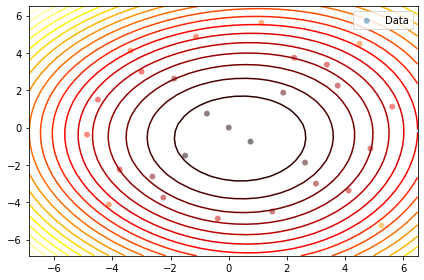

In [8]:
model = GPy.models.GPRegression(Q, E, kernel=GPy.kern.RBF(2)+GPy.kern.White(2))
print(model)
model.optimize()
print(model)
model.plot()

In [9]:
maximum = opt.maximize(lambda q1, q2: expected_improvement(q1, q2, 2, model), q1=[-6,6], q2=[-6,6])[0]
print(maximum)
print(Q.shape)
Q2 = Q
print(np.row_stack((Q2, np.array([maximum['q1'], maximum['q2']]))).shape)
print(Q2.shape)
print(E.shape)
print(np.append(E, np.array([10]).reshape(-1,1), axis=0).shape)

{'q1': -0.10546875, 'q2': -0.97265625}
(30, 2)
(31, 2)
(30, 2)
(30, 1)
(31, 1)


In [79]:
Q_new = Q.copy()
E_new = E.copy()
predicted = np.zeros(30)
for i in range(30):
    model = GPy.models.GPRegression(Q_new, E_new, kernel=GPy.kern.RBF(2)+GPy.kern.White(2))
    model.optimize()
    
    E_best = np.min(model.predict(Q_new)[0])
    
    maximum = opt.maximize(lambda q1, q2: expected_improvement(q1, q2, E_best, model), q1=[-6,6], q2=[-6,6])[0]
    q = np.array([maximum['q1'], maximum['q2']])
    Q_new = np.row_stack((Q_new, q))
    E_new = np.append(E_new, np.array([f(q[0], q[1])]).reshape(-1,1), axis=0)
    
    predicted[i] = model.predict(q.reshape(-1,1).T)[0][0][0]
    print(Q_new[-1], E_new[-1])

[ 0.5071875  -0.46222082] [0.03053955]
[ 0.85824267 -0.28323244] [2.59691197]
[ 0.13570312 -0.52054688] [1.79944773]
[ 0.2821875  -0.80039367] [2.24818293]
[ 0.45566793 -0.84117188] [1.6989366]
[ 0.51824248 -0.5315625 ] [0.02749043]
[ 0.74507812 -0.37992188] [1.31492941]
[ 0.01474978 -0.54398438] [2.27105663]
[ 0.72809333 -0.60080238] [1.11893484]
[ 0.02089856 -0.82668153] [3.79102908]
[-0.02297315 -0.3777897 ] [2.55864485]
[ 0.22709478 -0.64233127] [1.61208719]
[ 0.87796875 -0.27685904] [2.74486464]
[ 0.9759375  -0.77005204] [3.41369489]
[ 0.45445313 -0.41929688] [0.17508833]
[ 0.78839226 -0.35054046] [1.7538721]
[ 0.53949435 -0.24138916] [1.15314807]
[ 0.41179688 -1.12664063] [2.24991498]
[-0.07523438 -0.78799273] [3.540626]
[-0.0422458 -0.3290625] [2.81164431]
[ 0.444375   -0.22065863] [1.32489715]
[ 0.89554688 -0.62789062] [2.27092155]
[ 0.61786006 -0.78190123] [1.55435451]
[0.4696875  1.22172635] [4.1600587]
[ 0.13368734 -0.55105143] [1.85527291]
[ 0.64945313 -0.61429688] [0.69181

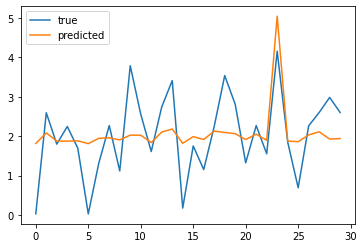

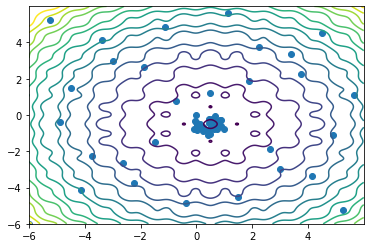

In [80]:
true_values = f(Q_new[30:,0], Q_new[30:,1])
plt.plot(np.arange(0,30), true_values, label="true")
plt.plot(np.arange(0,30), model.predict(Q_new[30:])[0], label="predicted")
plt.legend()

fig = plt.figure()
x = y = np.arange(-6.0, 6.0, 0.01)
X, Y = np.meshgrid(x, y)
zs = np.array(f(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)
levels = np.linspace(1, 75, 15)

CS = plt.contour(X, Y, Z, levels=levels)
plt.scatter(Q_new[:,0], Q_new[:,1])

In [81]:
def GPy_variance(q1, q2, model):
    mean_q, var_q = model.predict(np.array([q1, q2]).reshape(-1,1).T)
    return var_q
Q_new = Q.copy()
E_new = E.copy()
predicted = np.zeros(30)
for i in range(30):
    model = GPy.models.GPRegression(Q_new, E_new, kernel=GPy.kern.RBF(2)+GPy.kern.White(2))
    model.optimize()
    
    E_best = np.min(model.predict(Q_new)[0])
    
    if i % 2 == 0:
        maximum = opt.maximize(lambda q1, q2: expected_improvement(q1, q2, E_best, model), q1=[-6,6], q2=[-6,6])[0]
    else:
        maximum = opt.maximize(lambda q1, q2: GPy_variance(q1, q2, model), q1=[-6,6], q2=[-6,6])[0]
    q = np.array([maximum['q1'], maximum['q2']])
    Q_new = np.row_stack((Q_new, q))
    E_new = np.append(E_new, np.array([f(q[0], q[1])]).reshape(-1,1), axis=0)
    
    predicted[i] = model.predict(q.reshape(-1,1).T)[0][0][0]
    print(Q_new[-1], E_new[-1])

[ 0.59277316 -0.67732516] [0.76426183]
[-3.609375 -5.765625] [45.93877622]
[ 0.22851562 -1.15807264] [3.1873561]
[-1.28827818  5.68457847] [42.80917563]
[ 0.43480061 -0.49428242] [0.08767251]
[5.02734375 5.89453125] [65.16049541]


 C:\Users\nwolf\Anaconda3\envs\ml_homework\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\nwolf\Anaconda3\envs\ml_homework\lib\site-packages\GPy\kern\src\rbf.py:52: RuntimeWarning:overflow encountered in square
 C:\Users\nwolf\Anaconda3\envs\ml_homework\lib\site-packages\GPy\kern\src\rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[ 0.6178125  -0.26146691] [1.26048319]
[ 2.53640625 -5.94066069] [35.70508462]
[ 0.88282433 -0.19064096] [3.3476356]
[-5.94467203  2.11453125] [52.06180747]
[ 1.15623629 -0.64546875] [2.39687187]
[-5.28026929  5.62911813] [72.09998323]
[ 0.27752617 -0.58429687] [1.02152701]
[-4.44726562  5.98242188] [68.54553017]
[ 0.37873231 -0.0187487 ] [2.51588502]
[-5.9772395  -3.94493861] [57.75277537]
[ 0.03609375 -0.78421875] [3.48373402]
[ 5.07511024 -5.95525626] [54.54288812]
[0.69234375 0.03827698] [2.94356386]
[-5.93554688  1.47070312] [47.23594275]
[ 0.13700188 -0.47132812] [1.8005978]
[5.49292648 5.2294806 ] [58.88582053]
[-0.17178969 -0.69733624] [2.63722169]
[ 5.65851562 -0.32648437] [27.63443234]
[ 0.4511869  -0.27915883] [0.9156319]
[ 5.953125 -5.953125] [63.3870252]
[ 0.37007812 -1.08492187] [2.53510024]
[5.73191144 1.67689177] [33.55497798]
[ 0.57515625 -0.52828125] [0.13163439]
[ 5.97070312 -1.43554688] [32.86783227]


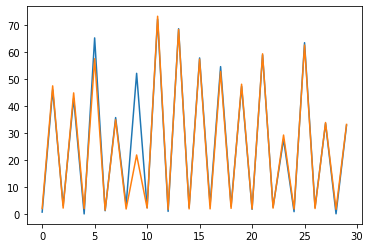

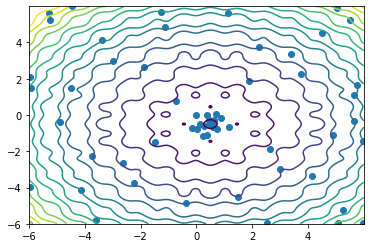

In [82]:
true_values = f(Q_new[30:,0], Q_new[30:,1])
plt.plot(np.arange(0,30), true_values)
plt.plot(np.arange(0,30), predicted)

fig = plt.figure()
x = y = np.arange(-6.0, 6.0, 0.01)
X, Y = np.meshgrid(x, y)
zs = np.array(f(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)
levels = np.linspace(1, 75, 15)

CS = plt.contour(X, Y, Z, levels=levels)
plt.scatter(Q_new[::,0], Q_new[::,1])

 C:\Users\nwolf\Anaconda3\envs\ml_homework\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x24b15864fd0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x24b15864ee0>]}

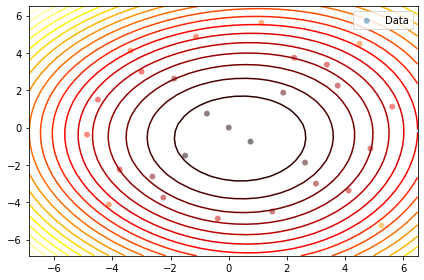

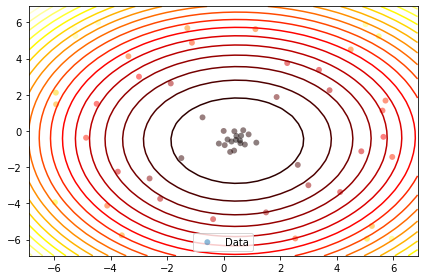

In [83]:
model = GPy.models.GPRegression(Q, E, kernel=GPy.kern.RBF(2)+GPy.kern.White(2))
model.optimize()
model.plot()

model = GPy.models.GPRegression(Q_new, E_new, kernel=GPy.kern.RBF(2)+GPy.kern.White(2))
model.optimize()
model.plot()

In [95]:
opt_print = lambda *args, **kwargs: None  # silence output

# opt_print = print # for debugging

def gaussian_kernel(data, sigma, max_distance):
    """Compute the gaussian kernel matrix.

    :param data: data matrix
    :param sigma: parameter sigma of the gaussian kernel
    :return: gaussian kernel matrix
    """
    assert len(data.shape) == 2
    assert sigma > 0

    factor = -0.5 / (sigma ** 2)
    limit = np.exp(factor * max_distance ** 2)
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        d = np.exp(factor * np.sum((data - k) ** 2, axis=1))
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:, None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K

def generalized_exp_kernel(data, sigma, gamma, max_distance):
    assert len(data.shape) == 2
    assert sigma > 0

    factor = 1 / (sigma ** 2)
    limit = np.exp(factor * max_distance ** 2)
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        d = np.exp(-np.sqrt(factor * np.sum((data - k) ** 2, axis=1))**gamma)
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:, None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K


def compute_alpha(train_x, train_y, tau, sigma, gamma, max_distance, verbose=False):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param sigma: parameter sigma of the gaussian kernel
    :param verbose: Print debugging information?
    :return: alpha vector
    """
    if verbose: print("Building input kernel matrix")
    K = generalized_exp_kernel(train_x, sigma, gamma, max_distance)
    if verbose: print("Sparsity is: %.2f%%" % (
            float(100 * K.nnz) / (K.shape[0] * K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:, None])
    if verbose: print("Solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    if verbose: print("Done computing alpha")
    return alpha[0]


class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau, sigma, gamma):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.sigma = sigma
        self.gamma = gamma
        self.scale = -0.5 / sigma**2
        self.max_distance = 4.0*sigma

    def train(self, train_x, train_y, verbose=False):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(np.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau,
                                   self.sigma, self.gamma, self.max_distance,
                                   verbose=verbose)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        indices = np.asarray(
            self.tree.query_ball_point(pred_x, self.max_distance),
            dtype=np.dtype("i8"))
        dist = np.sum((self.train_x[indices] - pred_x) ** 2, axis=1)
        kappa = np.exp(self.scale * dist)
        pred_y = np.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(np.float32)
        return np.array([self.predict_single(x) for x in pred_x])


def kernel_ridge_regression(tau, sigma, gamma, verbose=False):
    # Load the image.
    im_orig = np.squeeze(plt.imread("cc_90.png"))

    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = np.array(im_orig)

    # Find the known pixels and the pixels that shall be predicted.
    known_ind = np.where(im != 0)
    # predict everywhere, use im == 0 to predict only unfilled values
    unknown_ind = np.where(im >= 0)
    known_x = np.array(known_ind).transpose()
    known_y = np.array(im[known_ind])
    pred_x = np.array(unknown_ind).transpose()

    # Train and predict with the given regressor.
    start = time.time()
    if verbose: print("Training...")
    r = KernelRidgeRegressor(tau, sigma, gamma)
    r.train(known_x, known_y, verbose=verbose)
    if verbose: print("Done training.")

    if verbose: print("Predicting... ", end="")
    pred_y = r.predict(pred_x)
    if verbose: print("Done.")

    # Write the predicted values back into the image and show the result.
    im[unknown_ind] = pred_y
    stop = time.time()
    if verbose: print("Train and predict took %.02f seconds." % (stop - start))
    if verbose: print(im.shape)

    return im

In [91]:
result = kernel_ridge_regression(0.8, 3.0, 1.0)

(338, 250)


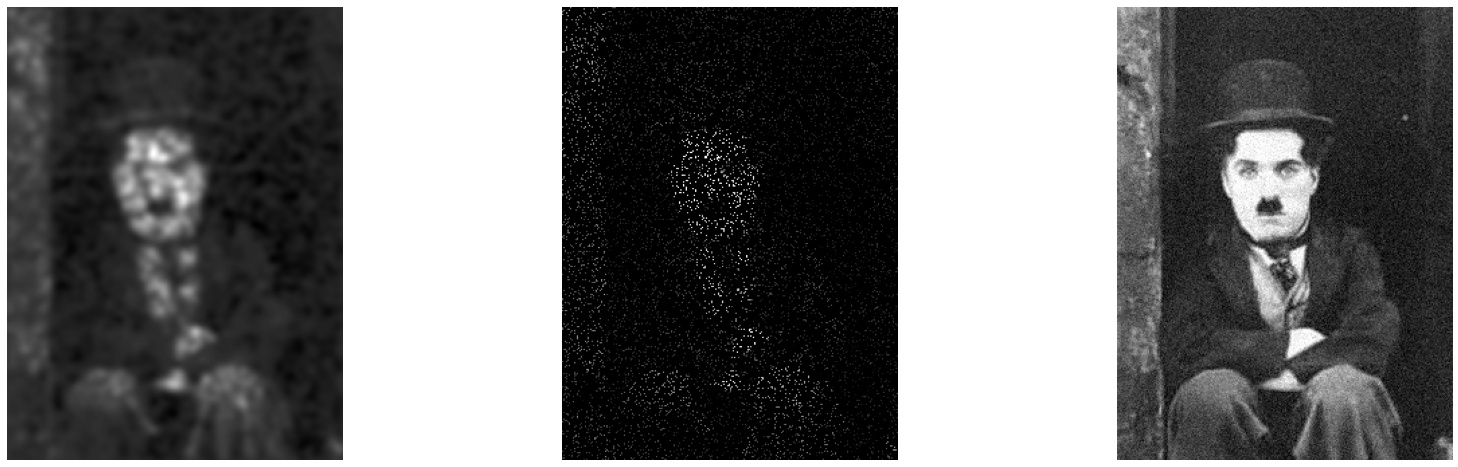

In [92]:
print(result.shape)
fig, axs = plt.subplots(1,3,figsize=(2.5*338/30, 250/30))
axs[0].imshow(result, cmap="gray")
axs[0].axis("off")
axs[1].imshow(np.squeeze(plt.imread("cc_90.png")), cmap="gray")
axs[1].axis("off")
axs[2].imshow(np.squeeze(plt.imread("charlie-chaplin.jpg")), cmap="gray")
axs[2].axis("off");

In [93]:
B = np.squeeze(plt.imread("charlie-chaplin.jpg"))
B_mean = np.mean(B)
B_diff = B - B_mean
def cor(tau, sigma, gamma):
    A = kernel_ridge_regression(tau, sigma, gamma)
    A_diff = A - np.mean(A)
    return np.sum(A_diff * B_diff) / np.sqrt(np.sum(A_diff**2) * np.sum(B_diff**2))
print(cor(0.8, 3.0, 1.0))

0.889976075530363


In [96]:
number_of_samples = 30
parameterUpperLimits = np. array ([1, 7, 4])
parameterLowerLimits = np. array ([0.005, 1, 1])
Q = np.zeros((number_of_samples, 3))
E = np.zeros(number_of_samples)
for i in range ( number_of_samples ):
    if i > 0 and i % 10 == 0:
        print(i)
    Q[i] = sobol.i4_sobol(3 ,i) [0] * ( parameterUpperLimits - parameterLowerLimits ) + parameterLowerLimits
    E[i] = 1 - cor(*Q[i])


10
20


In [103]:
def expected_improvement(q1, q2, q3, E_best, model):
    mean_q, var_q = model.predict(np.array([q1, q2, q3]).reshape(-1,1).T)
    mean_q = mean_q[0][0]
    std_q = np.sqrt(var_q[0][0])
    gamma_q = (E_best - mean_q) / std_q
    return std_q * (gamma_q * norm.cdf(gamma_q, loc=mean_q, scale=std_q) + norm.pdf(gamma_q, loc=mean_q, scale=std_q))

def GPy_variance(q1, q2, q3, model):
    mean_q, var_q = model.predict(np.array([q1, q2, q3]).reshape(-1,1).T)
    return var_q

Q_new = Q.copy()
E_new = E.copy().reshape(-1,1)
predicted = np.zeros(30)

for i in range(30):
    model = GPy.models.GPRegression(Q_new, E_new, kernel=GPy.kern.Matern52(3))
    model.optimize()
    
    E_best = np.min(model.predict(Q_new)[0])
    
    if i % 2 == 0:
        maximum = opt.maximize(lambda q1, q2, q3: expected_improvement(q1, q2, q3, E_best, model), 
                               q1=[0.005, 1], q2=[1, 7], q3=[1, 4])[0]
    else:
        maximum = opt.maximize(lambda q1, q2, q3: GPy_variance(q1, q2, q3, model), 
                               q1=[0.005, 1], q2=[1, 7], q3=[1, 4])[0]
        
    q = np.array([maximum['q1'], maximum['q2'], maximum['q3']])
    Q_new = np.row_stack((Q_new, q))
    E_new = np.append(E_new, np.array([1-cor(*q)]).reshape(-1,1), axis=0)
    
    predicted[i] = model.predict(q.reshape(-1,1).T)[0][0][0]
    print(Q_new[-1], E_new[-1])


[0.63097549 3.06285156 1.46743055] [0.10948748]
[0.12654505 5.67969858 3.83533351] [0.12363404]
[0.99125488 6.51367188 1.37207031] [0.13408518]
[0.76947712 1.06000448 3.34850567] [0.25689757]
[0.83918701 6.76855469 2.64501953] [0.13739504]
[0.91789307 1.81738281 3.86083984] [0.1469297]
[0.77285718 3.22554362 1.21946839] [0.10845025]
[0.89432123 1.08818219 1.68869553] [0.24965121]
[0.3927002  3.74804688 1.62988281] [0.10778576]
[0.68007263 6.89424284 3.73158297] [0.13903271]
[0.38638428 3.49902344 1.76025391] [0.10766032]
[0.0325661  6.84229743 1.10308285] [0.13835576]
[0.22306932 3.7346875  2.00611215] [0.10776186]
[0.59165894 1.44130962 1.03463384] [0.18407677]
[0.23048183 3.36530388 3.82550781] [0.1079109]
[0.60792725 1.31933594 3.90478516] [0.20227367]
[0.93684908 3.54167969 2.45553286] [0.10762978]
[0.89554443 3.70996094 3.97509766] [0.10772104]
[0.63394883 3.55748225 2.12664063] [0.10762469]
[0.70100128 6.54558475 3.99061282] [0.13449849]
[0.3110791  3.58398438 1.07910156] [0.1076

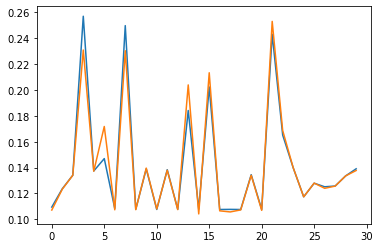

In [105]:
plt.plot(np.arange(0,30), E_new[30:])
plt.plot(np.arange(0,30), predicted)

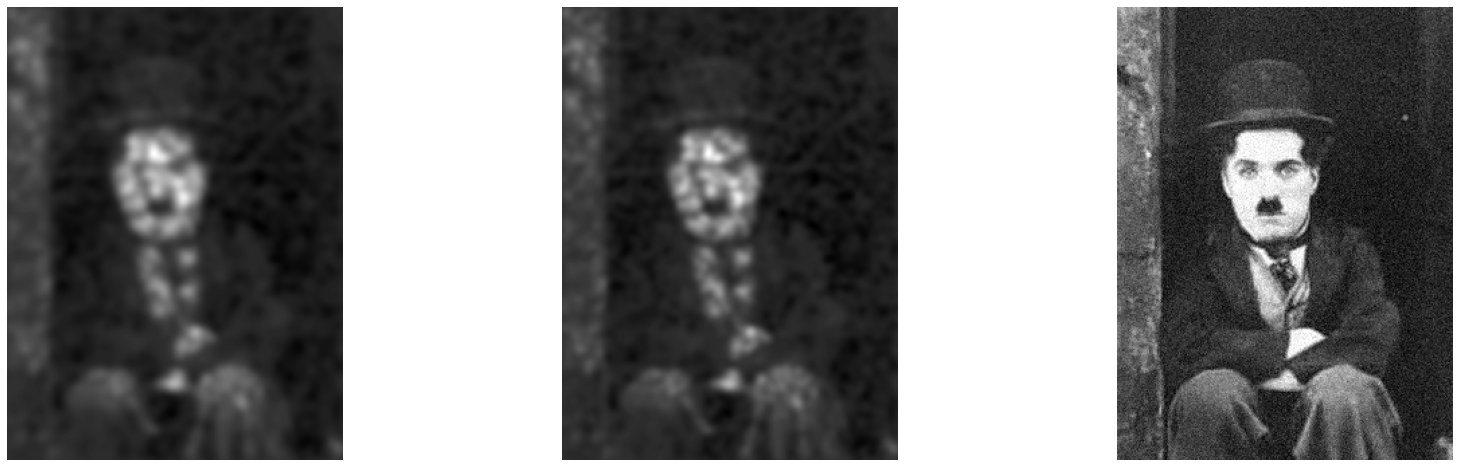

In [107]:
fig, axs = plt.subplots(1,3,figsize=(2.5*338/30, 250/30))
axs[0].imshow(kernel_ridge_regression(*Q_new[np.argmin(E_new)]), cmap="gray")
axs[0].axis("off")
axs[1].imshow(kernel_ridge_regression(0.8, 3.0, 1.0), cmap="gray")
axs[1].axis("off")
axs[2].imshow(np.squeeze(plt.imread("charlie-chaplin.jpg")), cmap="gray")
axs[2].axis("off");